In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import re
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 

%matplotlib inline

In [2]:
df = pd.read_csv('../../Data/bird_dataset.csv', index_col=0)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# Dropping columns with null values
bird_df = df.drop(columns=['SpecID', 'IOCOrder', 'BLFamilyLatin', 'BLFamilyEnglish', 'BLFamSequID', 'Taxo', 
                      'Scientific', 'English', 'Diet-Source', 'Diet-EnteredBy', 'ForStrat-Source',
                       'ForStrat-EnteredBy', 'BodyMass-Comment', 'BodyMass-Source', 'Record-Comment', 'Unnamed: 0.1', 
                      'English name', 'Family'])

In [4]:
dd_df = bird_df[bird_df['Global IUCN Red List Category'] == 'DD']

In [5]:
dd_df = dd_df.drop(columns=['Global IUCN Red List Category'])

In [6]:
# Dropping DD from bird_df
bird_df = bird_df.drop(index=dd_df.index)

In [7]:
# Creating target column
bird_df['threatened'] = [0.0 if x in ['NT', 'LC'] else 1.0 for x in bird_df['Global IUCN Red List Category']]

In [8]:
X = bird_df.drop(columns=['Global IUCN Red List Category', 'threatened'])
y = bird_df['threatened']

In [9]:
# Creating 10% holdout sets for testing the final model
X_t, X_hold, y_t, y_hold = train_test_split(X,y,random_state=42,stratify=y,test_size=0.1)

In [10]:
# Creating data for training (75% of original)/testing(15% of original)
X_train, X_test, y_train, y_test = train_test_split(X_t,y_t,random_state=42,stratify=y_t,test_size=15/90)

In [11]:
# Setting up some pipelines
# Numeric columns 
num_col = ['BodyMass-Value']
num_pipe = Pipeline([('min_max', MinMaxScaler())])

In [12]:
# Proportional numeric columns
diets = [c for c in X_train.columns if re.search('Diet.+',c)]
strats = [c for c in X_train.columns if re.search('ForStrat.+',c)]

diets = diets[:10]
strats = strats[:7]

prop_cols = strats+diets

prop_pipe = Pipeline([('div100', FunctionTransformer(lambda x: x/100))])

In [13]:
# Categorical columns
cat_cols = [c for c in X_train.columns if X_train[c].dtype=='object']

cat_pipe = Pipeline([('ohe', OneHotEncoder())])

In [22]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipe, num_col),
    ('proportional', prop_pipe, prop_cols),
    ('categorical', cat_pipe, cat_cols)
])

In [33]:
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                   ('dt', DecisionTreeClassifier())])

dt_grid = {'dt__max_depth': [3,5,50],
          'dt__min_samples_split': [2,5,10],
          'dt__criterion': ['gini', 'entropy']}

scoring_metrics = ['recall', 'f1']

dt_gs = GridSearchCV(estimator=dt_pipe, param_grid=dt_grid, scoring=scoring_metrics, refit='recall')

In [34]:
dt_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7fd0908ca700>))]),
                                                                         ['ForStrat-watbelowsurf',
                                                                          'ForStrat-wataroundsurf',
        

In [35]:
pd.DataFrame(dt_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.022142,0.003397,0.009289,0.001359,gini,3,2,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.069149,0.053191,...,0.024384,16,0.123223,0.092166,0.020942,0.067633,0.010417,0.062876,0.042503,16
1,0.021293,0.001370,0.007656,0.000216,gini,3,5,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.063830,0.053191,...,0.022952,18,0.113744,0.092166,0.020942,0.067633,0.010417,0.060980,0.039901,18
2,0.020721,0.001114,0.008738,0.001034,gini,3,10,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.069149,0.053191,...,0.024384,16,0.122642,0.092166,0.020942,0.067633,0.010417,0.062760,0.042339,17
3,0.024066,0.001905,0.008411,0.000467,gini,5,2,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.111702,0.031915,...,0.025501,13,0.188341,0.057692,0.127273,0.119816,0.132159,0.125056,0.041535,13
4,0.025860,0.002781,0.009189,0.000971,gini,5,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.101064,0.031915,...,0.022504,15,0.171171,0.057692,0.127273,0.119816,0.132159,0.121622,0.036574,15
5,0.027329,0.004554,0.009211,0.001511,gini,5,10,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.106383,0.031915,...,0.023955,14,0.179372,0.058252,0.127854,0.120370,0.132159,0.123601,0.038685,14
6,0.040184,0.000062,0.009150,0.001362,gini,50,2,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.239362,0.234043,...,0.017438,1,0.228426,0.228571,0.206718,0.226913,0.250000,0.228126,0.013701,1
7,0.042012,0.002158,0.008614,0.000832,gini,50,5,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.212766,0.255319,...,0.025865,4,0.220994,0.268156,0.209945,0.196429,0.230769,0.225259,0.024308,2
8,0.038748,0.000712,0.009130,0.001241,gini,50,10,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.148936,0.212766,...,0.021551,11,0.176656,0.241692,0.202454,0.182371,0.210863,0.202807,0.023145,10
9,0.041316,0.001713,0.008435,0.000274,gini,100,2,"{'dt__criterion': 'gini', 'dt__max_depth': 100...",0.218085,0.250000,...,0.019857,2,0.209719,0.242894,0.204082,0.211382,0.243038,0.222223,0.017109,4


AUC Score: 0.5514861335654769


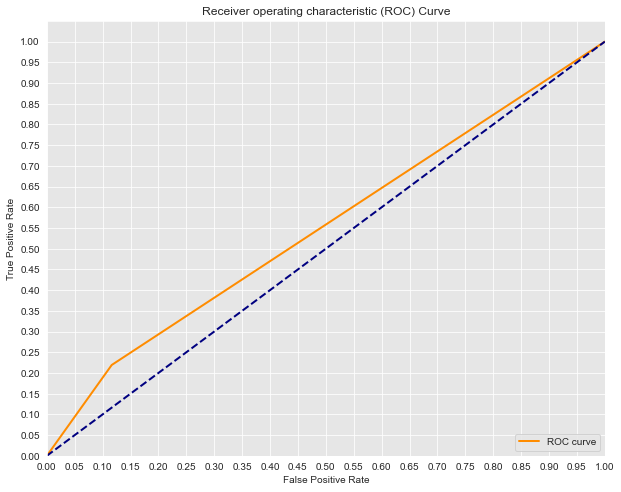

In [38]:
y_score = dt_gs.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();